# Embedding

The goal of this notebook is to perform different kinds of text embedding on the news headlines

# 0 Setup

In [1]:
%load_ext autoreload
%autoreload 2

import os
import pickle
import datetime
import numpy as np
import ast
from scipy.stats import t
from pandas.api.indexers import FixedForwardWindowIndexer
import yaml
from tqdm import tqdm
from dotenv import load_dotenv
from collections import Counter
from alpaca_api import AlpacaRequester
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer
import torch
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error

tqdm.pandas()

In [2]:
with open('config.yaml', 'r') as f:
    config = yaml.safe_load(f)

START = str(config['START'])
END = str(config['END'])
PREDICTION_DELTA = config['PREDICTION_DELTA']
OPEN_CUTOFF = config['OPEN_CUTOFF']
CLOSE_CUTOFF = config['CLOSE_CUTOFF']
FWD_WINDOW = config['FWD_WINDOW']
BACK_WINDOW = config['BACK_WINDOW']

In [3]:
df = pd.read_parquet('news/labelled_news.parquet')
df

,created_at,updated_at,headline,symbol,t,impact,impact_old,impact_mag,impact_old_mag
0,2020-01-14 11:37:55-05:00,2020-01-14 11:37:55-05:00,American Airlines Anticipates That Resumption ...,AAL,2020-01-14 11:37:00-05:00,-1.929170,-1.500926,1.929170,1.500926
1,2020-01-14 15:45:57-05:00,2020-01-14 15:45:57-05:00,American Airlines Delays Starting 737 MAX Serv...,AAL,2020-01-14 15:45:00-05:00,-0.985275,-0.885881,0.985275,0.885881
2,2020-01-16 15:35:54-05:00,2020-01-16 15:35:54-05:00,5 Reasons To Invest In Spirit Airlines Stock,AAL,2020-01-16 15:35:00-05:00,1.605030,1.049058,1.605030,1.049058
3,2020-01-22 13:50:38-05:00,2020-01-22 13:50:38-05:00,Q4 Earnings Preview For American Airlines Group,AAL,2020-01-22 13:50:00-05:00,1.096184,1.105646,1.096184,1.105646
4,2020-01-23 11:14:16-05:00,2020-01-23 11:14:16-05:00,PreMarket Prep Recap: Coronavirus Concerns Res...,AAL,2020-01-23 11:14:00-05:00,-0.176862,-0.260660,0.176862,0.260660
...,...,...,...,...,...,...,...,...,...
401,2025-06-09 12:04:38-04:00,2025-06-09 12:04:39-04:00,Oracle To Rally Around 15%? Here Are 10 Top An...,ZS,2025-06-09 12:04:00-04:00,0.174626,-0.064183,0.174626,0.064183
402,2025-06-11 09:46:18-04:00,2025-06-11 09:46:18-04:00,Cantor Fitzgerald Maintains Overweight on Zsca...,ZS,2025-06-11 09:46:00-04:00,-0.964359,-0.787446,0.964359,0.787446
403,2025-06-24 15:12:46-04:00,2025-06-24 15:12:46-04:00,3 Cybersecurity ETFs To Gain Ground As Threats...,ZS,2025-06-24 15:12:00-04:00,-0.125792,0.476880,0.125792,0.476880
404,2025-06-27 10:00:59-04:00,2025-06-27 10:00:59-04:00,47 Analysts Have This To Say About Zscaler,ZS,2025-06-27 10:00:00-04:00,0.469322,0.317546,0.469322,0.317546


In [4]:
def classify(i):
    if i >= 2:
        return 1
    elif i <= -2:
        return -1
    else:
        return 0

df['bucket'] = df['impact'].apply(classify)

In [5]:
symbols = set(df.symbol)

In [6]:
if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')

print(f"Using device: {device}")

Using device: mps


# Pretrained transformer encoder

In [7]:
# 1. Load a pretrained Sentence Transformer model

model = SentenceTransformer("all-MiniLM-L6-v2")
model.to(device)
None

In [8]:
embeddings = model.encode(df['headline'].tolist(), device=device, show_progress_bar=True)

Batches:   0%|          | 0/3360 [00:00<?, ?it/s]

In [9]:
df['embeddings'] = pd.Series([x for x in embeddings])
print(df.columns)
print(type(df.embeddings.iloc[0]))
print(type(df.embeddings.iloc[0][0]))
print(type(df.impact.iloc[0]))
print(type(df.symbol.iloc[0]))
print(len(df.symbol.unique()))
df = df.dropna(subset=['impact']).copy()
df['impact'] = df['impact'].clip(-8,8)

Index(['created_at', 'updated_at', 'headline', 'symbol', 't', 'impact',
       'impact_old', 'impact_mag', 'impact_old_mag', 'bucket', 'embeddings'],
      dtype='object')
<class 'numpy.ndarray'>
<class 'numpy.float32'>
<class 'numpy.float64'>
<class 'str'>
100


In [12]:
df['embeddings'] = pd.Series([x for x in embeddings])
print(df.columns)
print(type(df.embeddings.iloc[0]))
print(type(df.embeddings.iloc[0][0]))
print(type(df.bucket.iloc[0]))
print(df.bucket.unique())
print(type(df.symbol.iloc[0]))
print(len(df.symbol.unique()))

Index(['created_at', 'updated_at', 'headline', 'symbol', 't', 'impact',
       'impact_old', 'impact_mag', 'impact_old_mag', 'bucket', 'embeddings'],
      dtype='object')
<class 'numpy.ndarray'>
<class 'numpy.float32'>
<class 'numpy.int64'>
[ 0 -1  1]
<class 'str'>
100


In [39]:
flatten_emb

,func,<function <la...t 0x31479f380>
,inverse_func,None
,validate,False
,accept_sparse,False
,check_inverse,True
,feature_names_out,<function <la...t 0x31479f600>
,kw_args,None
,inv_kw_args,None


In [41]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.compose import ColumnTransformer, make_column_selector as selector
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, f1_score
from sklearn.linear_model import LogisticRegression
from collections import Counter

# --- 1. PREPROCESS ---------------------------------------------------------
flatten_emb = FunctionTransformer(
    func=lambda col: np.stack(col.squeeze()),
    validate=False,
    feature_names_out=lambda col: [
        f"e{i}" for i in range(col.squeeze().iloc[0].shape[0])
    ],
)

preprocess = ColumnTransformer(
    transformers=[
        ("emb", Pipeline([
            ("flatten", flatten_emb),
            ("scale", StandardScaler())
        ]), ["embeddings"]),
        ("sym", OneHotEncoder(handle_unknown="ignore", sparse_output=True), ["symbol"]),
    ],
    remainder="drop",
)

# --- 2. MODEL --------------------------------------------------------------
y = df["bucket"]
X = df[["embeddings", "symbol"]]

class_weights = (len(y) / y.value_counts()).to_dict()

clf = Pipeline([
    ("prep", preprocess),
    ("clf", LogisticRegression(
        max_iter=200,
        class_weight=class_weights,
        multi_class="ovr",
        n_jobs=-1,
    )),
])

# --- 3. TRAIN / VALIDATE ---------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(clf, X_train, y_train,
                            scoring="f1_macro", cv=cv, n_jobs=-1)
print(f"CV macro‑F1: {cv_scores.mean():.3f} ± {cv_scores.std():.3f}")

clf.fit(X_train, y_train)
print(classification_report(y_test, clf.predict(X_test), digits=3))


/Users/isaia/headlines/.venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1281: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/isaia/headlines/.venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1281: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/isaia/headlines/.venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1281: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/isaia/headlines/.venv/lib/python3.13/site-packages/sklear

CV macro‑F1: 0.232 ± 0.003


/Users/isaia/headlines/.venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1281: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


              precision    recall  f1-score   support

          -1      0.059     0.330     0.100      1230
           0      0.895     0.347     0.501     19050
           1      0.064     0.383     0.110      1208

    accuracy                          0.348     21488
   macro avg      0.339     0.354     0.237     21488
weighted avg      0.800     0.348     0.456     21488



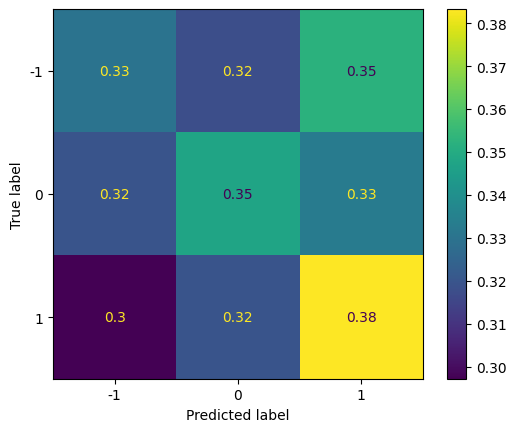

In [42]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test,
                                      display_labels=[-1,0,1], normalize='true')


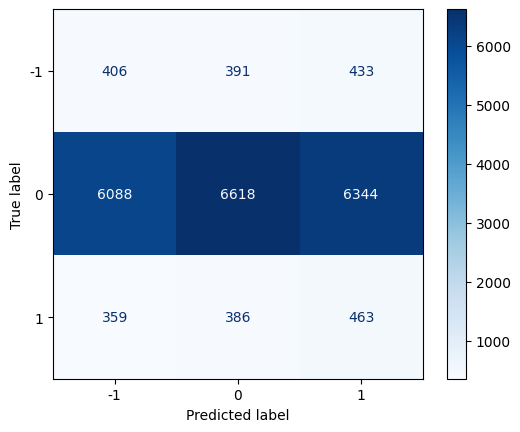

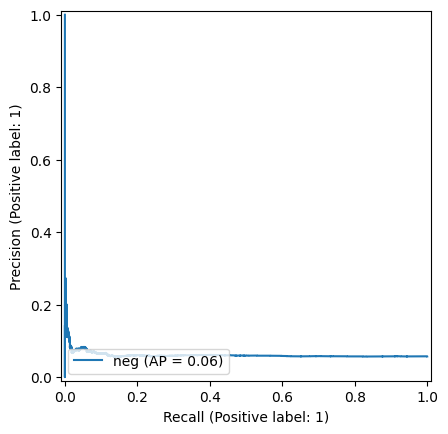

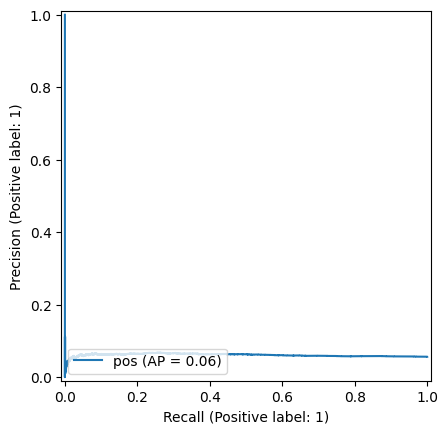

In [43]:
# 1️⃣ absolute CM to verify real counts
ConfusionMatrixDisplay.from_estimator(
    clf, X_test, y_test, labels=[-1,0,1], cmap="Blues"
)

# 2️⃣ PR curves for ±1
from sklearn.metrics import PrecisionRecallDisplay
for c, label in [(-1,"neg"), (1,"pos")]:
    PrecisionRecallDisplay.from_predictions(
        (y_test==c).astype(int), clf.predict_proba(X_test)[:, clf.classes_==c].ravel(),
        name=label
    )
